In [1]:
import scrapy
from scrapy_selenium import SeleniumRequest
SeleniumRequest()
import shutil
shutil.which('/usr/bin/chromedriver')
shutil.which('/Users/alex/chromedriver')

In [ ]:
! scrapy shell https://getbootstrap.com/docs/4.0/content/tables/

In [67]:
t = pd.read_csv(article_version_fs[0], index_col=0)

In [86]:
import pyperclip

In [88]:
pyperclip.copy(str(t.iloc[0].apply(type)))

In [44]:
search_pages = glob.glob('cache/newssniffer-index-*')
files = list(map(lambda x: pd.read_csv(x, index_col=0), search_pages))
files_df = pd.concat(files).reset_index(drop=True)
files_df['file_id'] = files_df['newssniff_link'].str.split('/').str.get(4)

## get max version per file
max_diff_per_file_id = (files_df[['version', 'file_id']]
                        .assign(version=lambda df: df['version'].astype(int))
                        .groupby('file_id')
                        ['version'].max()
)
## merge
files_df = files_df.merge(
    max_diff_per_file_id.astype(int).to_frame('num_diffs_per_file'),
    left_on='file_id',
    right_index=True
).drop_duplicates('file_id')

## get already parsed files
article_version_fs = glob.glob('cache/article-versions-*')
article_version_dfs = list(map(lambda x: pd.read_csv(x, usecols=['file_id']), article_version_fs))
existing_files = pd.concat(article_version_dfs)
existing_ids= existing_files['file_id'].drop_duplicates()

## get percenilte cutoffs
min_cut, max_cut = files_df['num_diffs_per_file'].loc[lambda s: s != 0].quantile([.01, .99])
to_scrape_table = (
    files_df
        .loc[lambda df: df['num_diffs_per_file'].pipe(lambda s: (s >= min_cut) & (s <= max_cut))]  ## 1, 30
        [['file_id', 'num_diffs_per_file']]
        .drop_duplicates()
        .loc[lambda df: ~df['file_id'].astype(int).isin(existing_ids.values)]
)

In [45]:
to_scrape_table

,file_id,num_diffs_per_file
21,1709241,5
22,1709294,10
23,1689248,3
24,1591586,2
25,1665257,3
...,...,...
951677,1680269,1
951696,1680236,2
951704,1680224,1
951714,1680210,1


In [47]:
urls_to_scrape = []
for file_id, num_diffs in to_scrape_table.itertuples(index=False):
    v = list(range(num_diffs+1))
    for s, e in list(zip(v[:-1], v[1:])):
        url = 'https://www.newssniffer.co.uk/articles/%s/diff/%s/%s' % (file_id, s, e)
        urls_to_scrape.append(url)

In [62]:
from pathlib import Path
import os

In [ ]:
os.path.exists('cache')
Path('cache')
Path('../cache').exists()

In [95]:
t = pd.read_csv(article_version_fs[0], index_col=0)

In [118]:
json_file = '../scraping/scrapy-cloud/newssniffer_scrape/output_dir/1-filename2021-01-14T23-11-04.987219.json'

In [ ]:
import json

t = []
for line in open(json_file):
    json_str = json.loads(line)
    t.append(json_str)

In [ ]:
json.loads()

In [133]:
t3 = pd.read_json(path_or_buf=json_file, orient='records', lines=True)

In [129]:
# t2.to_json(json_file, orient='records', lines=True)['article_id']

In [131]:
t2.shape

(5000, 8)

In [142]:
pd.concat([
    pd.read_csv('cache/article-versions-1000.csv')['file_id'],
    t2['article_id']
])

0       1683749
1       1683749
2       1683749
3       1683749
4       1683749
         ...   
4995    1669125
4996    1669125
4997    1669125
4998    1591175
4999    1591175
Length: 10346, dtype: int64

In [171]:
cache_dir = 'cache'
a_vers_fs = glob.glob(os.path.join(cache_dir, 'article-versions-*'))
a_vers_dfs = list(map(lambda x: pd.read_csv(x, usecols=['file_id'], squeeze=True), a_vers_fs))

## another path for the scrapy output
scrapy_cache_dir = '../scraping/scrapy-cloud/newssniffer_scrape/output_dir/'
a_vers_fs = (glob.glob(os.path.join(scrapy_cache_dir, '*article*')) +
                     glob.glob(os.path.join(scrapy_cache_dir, '*filename*')))
for f in a_vers_fs:
    try:
        df = pd.read_json(path_or_buf=f, orient='records', lines=True)
    except:
        df = pd.read_json(path_or_buf=f, orient='records', lines=False)
    if len(df)>0:
        a_vers_dfs.append(df['article_id'])

existing_files = pd.concat(a_vers_dfs)
existing_files.drop_duplicates().astype(int)

0       1741157
4       1598268
12      1742131
16      1742183
18      1741787
         ...   
4974    1590691
4978    1708357
4982    1614529
4988    1699322
4992    1699206
Length: 20818, dtype: int64

# Look at Server output

In [178]:
cache_dir = '../scraping/scrapy-cloud/newssniffer_scrape/output_dir/'
search_pages = glob.glob(os.path.join(cache_dir, 'newssniffer-index-*'))
files = list(map(lambda x: pd.read_csv(x, index_col=0), search_pages))
files_df = pd.concat(files).reset_index(drop=True)
files_df['file_id'] = files_df['newssniff_link'].str.split('/').str.get(4).astype(int)

## get max version per file
max_diff_per_file_id = (
    files_df[['version', 'file_id']]
        .assign(version=lambda df: df['version'].astype(int))
        .groupby('file_id')
        ['version'].max())
## merge
files_df = (files_df.merge(
            right=max_diff_per_file_id.astype(int).to_frame('num_diffs_per_file'),
            left_on='file_id', right_index=True
        ).drop_duplicates('file_id'))

In [191]:
min_cut, max_cut = files_df['num_diffs_per_file'].loc[lambda s: s != 0].quantile([.01, .99])
to_scrape_table = (
    files_df
         .loc[lambda df: df['num_diffs_per_file'].pipe(lambda s: (s >= min_cut) & (s <= max_cut))]  ## 1, 30
         [['file_id', 'num_diffs_per_file']]
         .drop_duplicates()
        .loc[lambda df: ~df['file_id'].astype(int).isin(existing_files.drop_duplicates().values)]
)


In [197]:
existing_files.drop_duplicates().to_csv('../scraping/scrapy-cloud/newssniffer_scrape/output_dir/file-ids-scraped.csv')

In [181]:
from tqdm.auto import tqdm

In [186]:
a_vers_fs = glob.glob(os.path.join(cache_dir, 'article-versions-*'))
a_vers_dfs = list(map(lambda x: pd.read_csv(x, usecols=['file_id'], squeeze=True), a_vers_fs))

## another path for the scrapy output
a_vers_fs = (
    glob.glob(os.path.join(cache_dir, '*-articles-*')) +
    glob.glob(os.path.join(cache_dir, '*filename*')) + 
    glob.glob(os.path.join(cache_dir, '*output*'))
)
for f in tqdm(a_vers_fs):
    try:
        df = pd.read_json(path_or_buf=f, orient='records', lines=True)
    except:
        df = pd.read_json(path_or_buf=f, orient='records', lines=False)
    if len(df)>0:
        a_vers_dfs.append(df['article_id'])

existing_files = pd.concat(a_vers_dfs)

  0%|          | 0/41 [00:00<?, ?it/s]

# Get article page files

In [238]:
import matplotlib.pyplot as plt
plt.rc('font', size=14)

In [210]:
f = '../scraping/scrapy-cloud/output_dir/search_output/output-8-8.json'

In [216]:
article_page_files = []
for f in tqdm(glob.glob('../scraping/scrapy-cloud/output_dir/search_output/*8*')):
    a = pd.read_json(f)
    a['file'] = f.split('/')[-1]
    article_page_files.append(a)

  0%|          | 0/8 [00:00<?, ?it/s]

In [218]:
article_page_file_df = pd.concat(article_page_files)

In [222]:
article_page_file_df['day_created'] = article_page_file_df['time_created'].str.split().apply(lambda x: x[:-1]).str.join(' ')

In [229]:
day_map = (article_page_file_df['day_created']
 .drop_duplicates()
 .to_frame()
 .assign(date=lambda df: pd.to_datetime(df['day_created']))
)

In [233]:
article_page_file_df = article_page_file_df.merge(day_map, left_on='day_created', right_on='day_created')

Text(0.5, 0, 'Date')

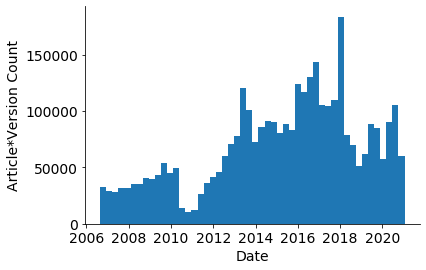

In [241]:
ax = article_page_file_df['date'].hist(bins=50)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Article*Version Count')
ax.set_xlabel('Date')

Text(0.5, 0, 'Num Versions')

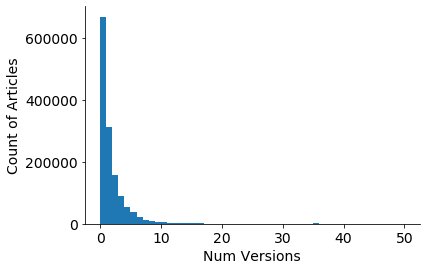

In [253]:
ax = article_page_file_df.groupby('article_id')['version'].max().hist(bins=50, range=(0,50))
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Count of Articles')
ax.set_xlabel('Num Versions')

In [254]:
num_versions_per_article = article_page_file_df.groupby('article_id')['version'].max()

In [259]:
article_page_file_df = article_page_file_df.merge(num_versions_per_article.to_frame('total_num_versions'),
                           left_on='article_id',
                           right_index=True
                          )

Text(0.5, 0, 'Date')

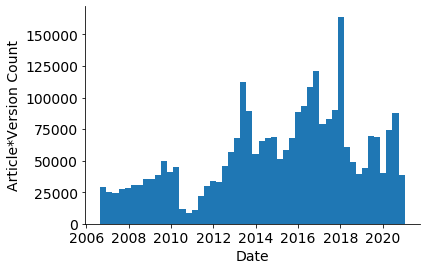

In [262]:
ax = (article_page_file_df
 .loc[lambda df: df['total_num_versions'] > 0]
 ['date']
 .hist(bins=50)
)

ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Article*Version Count')
ax.set_xlabel('Date')

## How well did we recover all the ids?

In [275]:
# article_page_file_df.groupby('file')['date'].aggregate(['min', 'max'])
article_page_file_df['file'].value_counts()

output-3-8.json    549636
output-8-8.json    484083
output-6-8.json    481482
output-5-8.json    472431
output-4-8.json    435255
output-7-8.json    407107
output-1-8.json    367002
output-2-8.json    273052
Name: file, dtype: int64

In [276]:
article_page_file_df.drop_duplicates('article_id')['file'].value_counts()

output-4-8.json    220831
output-3-8.json    212098
output-5-8.json    206723
output-6-8.json    190957
output-8-8.json    181504
output-7-8.json    176956
output-1-8.json    117001
output-2-8.json     87652
Name: file, dtype: int64

In [277]:
total_ids = pd.Series(list(range(35, 2058846)))

In [280]:
existing_ids = pd.read_csv('../scraping/scrapy-cloud/newssniffer_scrape/output_dir/file-ids-scraped.csv', index_col=0, squeeze=True)

In [286]:
(total_ids
 .loc[lambda s: ~s.isin(existing_ids)]
 .loc[lambda s: ~s.isin(article_page_file_df['article_id'].drop_duplicates())]
 .shape
)

## we're missing this many ids... probably should do another sweep here after it's all over.

(586398,)

In [ ]:
(total_ids
 .loc[lambda s: ~s.isin(existing_ids)]
 .loc[lambda s: ~s.isin(article_page_file_df['article_id'].drop_duplicates())]
 .reset_index(drop=True)
 .to_csv('../scraping/scrapy-cloud/newssniffer_scrape/output_dir/2021-01-17__article-page-ids-to-get.csv')
#  .shape
)

In [285]:
total_ids.loc[lambda s: ~s.isin(existing_ids)].shape

(1980120,)

In [287]:
existing_ids.shape

(78691,)

In [298]:
title_counts_across_articles = article_page_file_df.drop_duplicates('article_id')['title'].value_counts()

In [316]:
(article_page_file_df
 .loc[lambda df: df['total_num_versions'] > 0]
 ['version_url']
 .reset_index(drop=True)
 .to_csv('../scraping/scrapy-cloud/newssniffer_scrape/output_dir/version-urls.csv')
)

In [320]:
(article_page_file_df
 .loc[lambda df: df['total_num_versions'] > 0]
 ['version_url']
 .reset_index(drop=True)
 .values[100]
)

'https://www.newssniffer.co.uk/articles/79/versions/407'